# Bayesian Logistic Regression Modelling for Back Pain Abnormality
Numaer Zaker \<nzaker3@gatech.edu\><br/>
IsYE 6420 - Bayesian Statistics - Fall 2020<br/>
Georgia Institute of Technology<br/>
    
<hr/>
    
<h3>Summary</h3>    
This notebook contains runs the bayesian logistic regression model and also produces the visualizations shown in the report. The core bayesian functions are in the <b>bayes_project.py</b> file. You can also run that executable directly from the terminal.
    
<hr/>
<h3>References</h3>
<b>Dataset Source</b>: https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset <br>
<b>PyMC3 API Documentation</b>: https://docs.pymc.io/api.html

In [1]:
# UNCOMMENT BELOW IF MISSING DEPENDENCIES
#!pip install pymc3==3.9
#!pip install numpy==1.18.5
#!pip install pandas==1.0.5
#!pip install theano==1.0.4
#!pip install matplotlib==3.2.2
#!pip install scikit-learn==0.23.1
#!pip install seaborn==0.11.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pymc3 as pm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Ensure you are running the notebook in the same folder as "bayes_project.py"
from bayes_project import load_data, predict_spine_probability, split_data, bayesian_model, spine_features, calculate_model_performance

In [2]:
""" We read in the spine dataset into a pandas dataframe.
We encode our categorical variable, "back_status" into a binary variable
(Abnormal = 1, Normal = 0)

There are 310 data points and 15 columns. We only look at 13.
We use the describe() function to get descriptive statistics.
"""

raw_data = load_data()
print(raw_data.shape)
display(raw_data.head(1))
display(raw_data[raw_data.columns[:6]].describe())
display(raw_data[raw_data.columns[6:]].describe())

Load in and clean our data
(310, 15)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,back_status,notes,binary_back_status
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.2544,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN,1


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,binary_back_status
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981,0.677419
std,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558,0.468220
min,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900,0.000000
25%,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075,0.000000
50%,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950,1.000000
75%,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600,1.000000
max,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200,1.000000


,binary_back_status
pelvic_incidence,0.353336
pelvic_tilt,0.326063
lumbar_lordosis_angle,0.312484
sacral_slope,0.210602
pelvic_radius,-0.309857
degree_spondylolisthesis,0.443687
pelvic_slope,0.055865
direct_tilt,-0.039591
thoracic_slope,-0.049354
cervical_tilt,0.100044


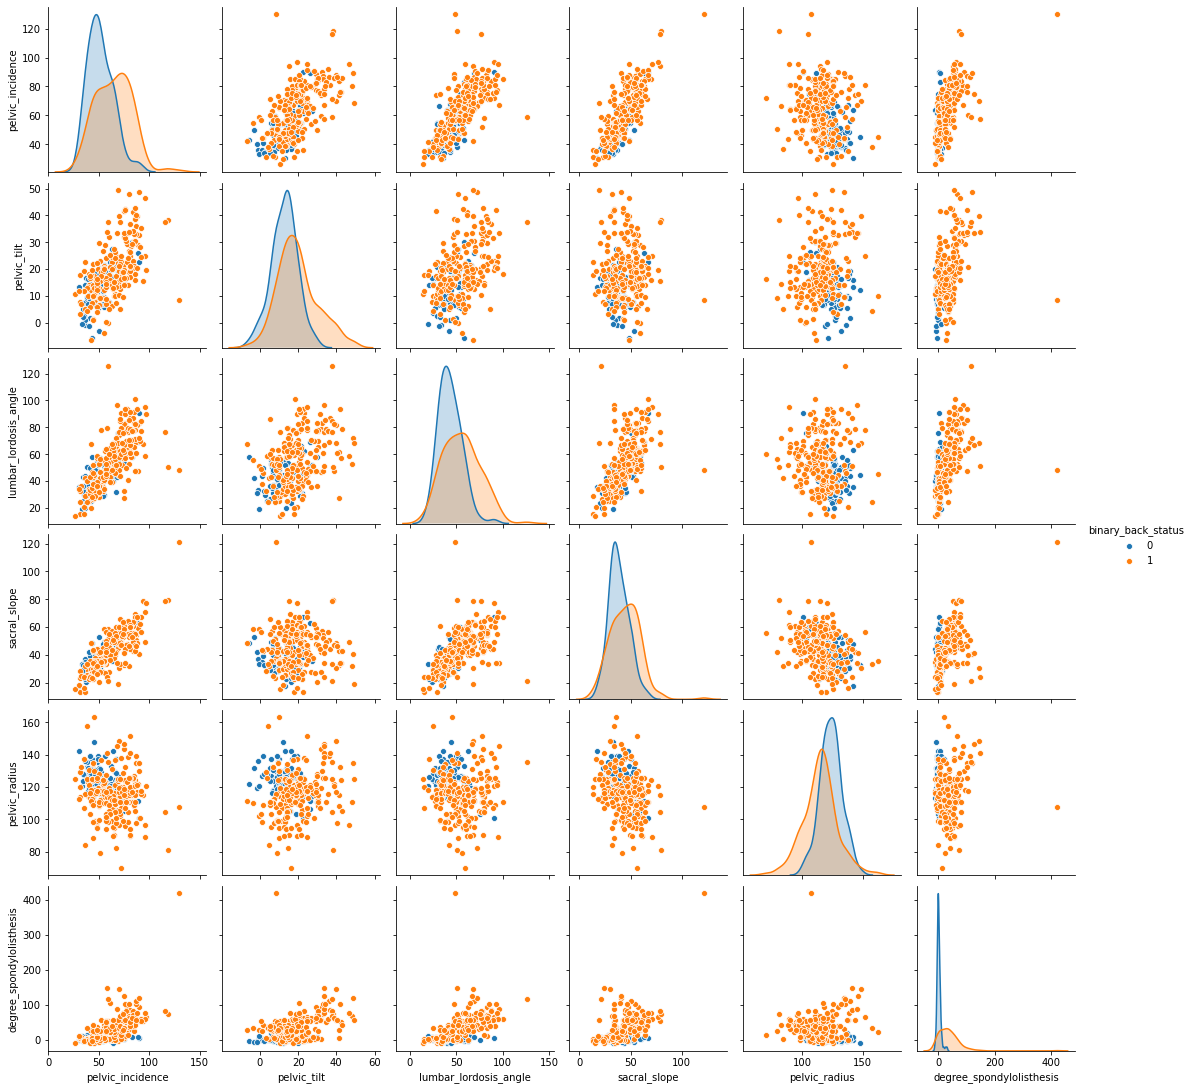

In [3]:
""" We show the correlation heatmap matrix between all our columns.
Prune features with high collinearity and weak correlation with responsee.
"""
cordata = raw_data[spine_features + ['binary_back_status']].corr()
display(cordata[['binary_back_status']])

""" Plot the scatterplot correlation matrix.
Colore ncoding abnormal=1 as orange, and normal=0 as blue. 
Further prune for features
"""
SELECTED_FEATURES = ['pelvic_incidence',
                     'pelvic_tilt', 
                      'lumbar_lordosis_angle',
                      'sacral_slope',
                      'pelvic_radius',
                      'degree_spondylolisthesis']

g = sns.pairplot(raw_data[SELECTED_FEATURES + ['binary_back_status']], hue="binary_back_status")

In [4]:
"""Sample to build our bayesian logistic regression model with specifications:

* beta coefficients follow noninformative priors of Normal(0, 1E-6)
* We use the No U-Turn (NUTS) sampler which on averaged converges faster than Gibbs and Metropolis-Hastings
* We run for 1000 samples

NOTE: If this part failed and you are on OSX; you are missing the C headers.

cd /Library/Developer/CommandLineTools/Packages/
open macOS_SDK_headers_for_macOS_10.14.pkg

Then install the C header.
"""

X_train, X_test, y_train, y_test, train_df = split_data(raw_data) # split data 80/20
trace = bayesian_model(train_df)
pm.summary(trace)

Split dataset into training and testing (80/20)
Beginning sampling progress for posteriors of beta random variables..


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [degree_spondylolisthesis, pelvic_radius, lumbar_lordosis_angle, pelvic_tilt, Intercept]
Sampling 4 chains, 0 divergences: 100%|█| 8000/8000 [00:35<00:00, 224.93draws/s
The acceptance probability does not match the target. It is 0.8948437398083625, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8902210588689019, but should be close to 0.8. Try to increase the number of tuning steps.


===== BAYESIAN LOGISTIC REGRESSION POSTERIOR STATISTICS =====
                           mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  \
Intercept                 9.952  2.774   4.994   15.335      0.075    0.054   
pelvic_tilt               0.113  0.033   0.051    0.176      0.001    0.001   
lumbar_lordosis_angle    -0.074  0.018  -0.110   -0.040      0.000    0.000   
pelvic_radius            -0.079  0.021  -0.119   -0.042      0.001    0.000   
degree_spondylolisthesis  0.169  0.026   0.122    0.222      0.001    0.000   

                          ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Intercept                   1358.0  1344.0    1362.0    1556.0    1.0  
pelvic_tilt                 2291.0  2158.0    2317.0    2052.0    1.0  
lumbar_lordosis_angle       1837.0  1837.0    1837.0    2249.0    1.0  
pelvic_radius               1414.0  1408.0    1417.0    1547.0    1.0  
degree_spondylolisthesis    1706.0  1660.0    1731.0    2328.0    1.0  


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,9.952,2.774,4.994,15.335,0.075,0.054,1358.0,1344.0,1362.0,1556.0,1.0
pelvic_tilt,0.113,0.033,0.051,0.176,0.001,0.001,2291.0,2158.0,2317.0,2052.0,1.0
lumbar_lordosis_angle,-0.074,0.018,-0.110,-0.040,0.000,0.000,1837.0,1837.0,1837.0,2249.0,1.0
pelvic_radius,-0.079,0.021,-0.119,-0.042,0.001,0.000,1414.0,1408.0,1417.0,1547.0,1.0
degree_spondylolisthesis,0.169,0.026,0.122,0.222,0.001,0.000,1706.0,1660.0,1731.0,2328.0,1.0


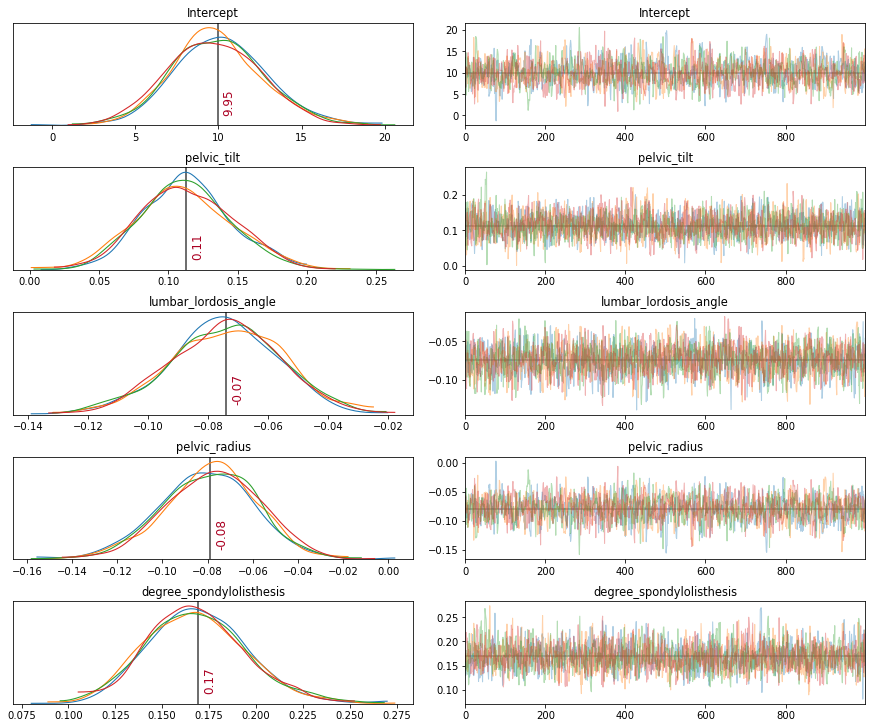

In [5]:
""" Plot our sample traces for each of our random variables. 

Left figures show posterior distributions for each of our random variables.
The right figures show convergence.
"""

ax = pm.traceplot(trace[-0:],
                  lines=tuple([(k, {}, v['mean'])
                               for k, v in pm.summary(trace[-0:]).iterrows()]))

for i, mn in enumerate(pm.summary(trace[-0:])['mean']):
    ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                ,xytext=(5,10), textcoords='offset points', rotation=90
                ,va='bottom', fontsize='large', color='#AA0022')

Testing model on test set...
===== MODEL PERFORMANCE ON TEST DATA =====
# Correctly Classified:  53
# Incorrectly Classified:  9
% Model Accuracy:  85.48


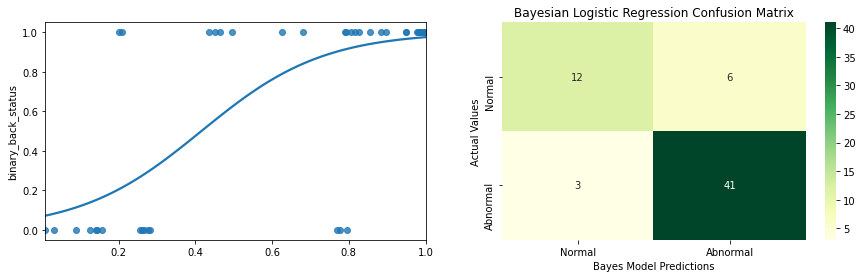

In [6]:
""" Below we plot how our logistic regression model classified points. 
Anywhere where x>0.5 it detects as abnormal back, whereas x<0.5 is normal back.
Where y=1 indicates the spine actually being abnormal and y=0 means a normal back. 

The confusion matrix and accuracy are also provided
"""

y_heat, y_hat_mean, y_hat_pred, prediction_results = calculate_model_performance(trace, X_test, y_test)
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(15)
sns.heatmap(confusion_matrix(y_hat_pred, y_test), annot=True, cmap="YlGn", ax=ax2)
ax2.set_title('Bayesian Logistic Regression Confusion Matrix'); 
ax2.set_xlabel('Bayes Model Predictions')
ax2.set_ylabel('Actual Values')
ax2.xaxis.set_ticklabels(['Normal', 'Abnormal'])
ax2.yaxis.set_ticklabels(['Normal', 'Abnormal'])
sns.regplot(y=y_test, x=y_hat_mean, logistic=True, ax=ax1)